## Интеллектуальный анализ данных – весна 2022
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [3]:
X.isnull().any().any() # тест показал, что явных пропусков в данных нет

False

In [4]:
# Проверим есть ли в наборе данных категориальные значения (тест показал, что есть только числовые)
X.dtypes


alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [6]:
# Вместо np.random.seed() используем random_state
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test= train_test_split(X, y, test_size=0.3, random_state=5) 

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [8]:
# Отмасштабируем данные и заодно выберем нужные alcohol и magnesium по заданию
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
normalizer = preprocessing.StandardScaler()
normalizer_fitted_for_alco_mag_train = normalizer.fit(X_train[['alcohol', 'magnesium']])
X_alco_mag_train = normalizer_fitted_for_alco_mag_train.transform(X_train[['alcohol', 'magnesium']])  
X_alco_mag_test = normalizer_fitted_for_alco_mag_train.transform(X_test[['alcohol', 'magnesium']])  

 
from sklearn.neighbors import KNeighborsClassifier
print('NN', 'Train', 'Test', sep='\t')
classifiers = list()
labels = list()
for k in [1, 3, 5, 10, 15, 25]:
    prediction = KNeighborsClassifier(n_neighbors=k, metric='euclidean').fit(X_alco_mag_train, Y_train)
    classifiers.append(prediction)  # это понадобится для графиков
    labels.append(f'n_neighbors={k}')  # нужно для названий графиков
    accuracy_train = np.mean(prediction.predict(X_alco_mag_train)== Y_train)  # проверяем соответствие пердсказаний правильным ответам
    accuracy_test = np.mean(prediction.predict(X_alco_mag_test)== Y_test)
    
    print(k, float('{:.2f}'.format(accuracy_train)), float('{:.2f}'.format(accuracy_test)), sep='\t')

NN	Train	Test
1	0.99	0.72
3	0.85	0.72
5	0.82	0.7
10	0.78	0.78
15	0.76	0.69
25	0.74	0.7


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [9]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [10]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(),

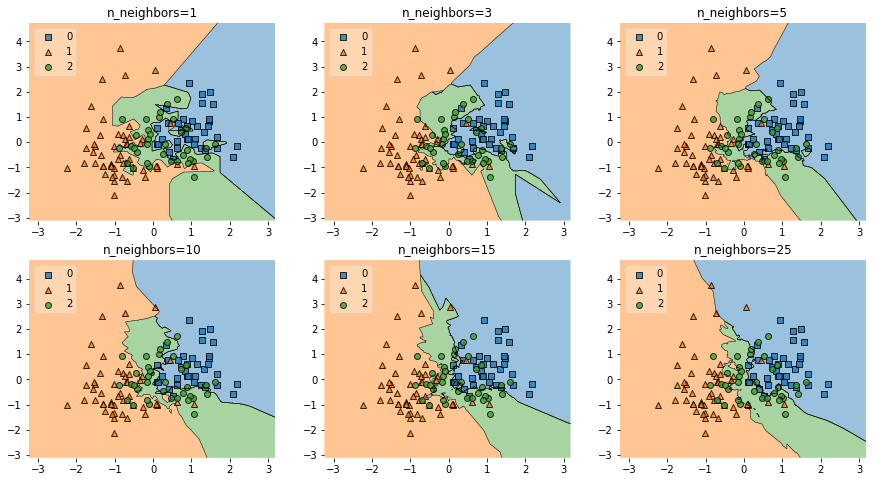

In [11]:
# код взят с http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(15,8))

for clf, lab, grd in zip(classifiers, labels, itertools.product([0, 1, 2], repeat=2)):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_alco_mag_train, y=Y_train, clf=clf, legend=2)  # выводим тренировочную выборку
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

Cоответствие предсказаний действительности больше на тренировочной выборке (в целом как и ожидалось). 
Самое большое accuracy для тестовой выборки - при  *k = 10* (но это меняется, если разбивать выборку по-разному). Поэтому из предложенных параметров *k = 10 - самый оптимальный для обучения модели*.

Стоит отметить также, что при увеличении k accuracy сначала падает, а потом возрастает, но всегда достигает своего максимума в k = 10.

На графиках заметно, как изменяется классификация в зависимости от количества соседей. 

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

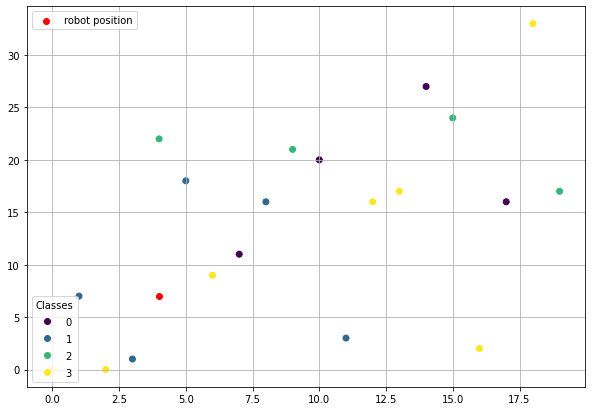

In [12]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        
        '''
        # Store the history of movements
        self.trajectory = [initial_position]  # создаем лист, в который потом будут складываться все точки
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean').fit(landmarks, classes)
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        '''
        Calculate new position of the robot and add it to the history
        '''
        
        if np.random.binomial(1, 0.8) == 1:  # если при биномиальном распределении с вероятностью 0.2 выпадет 1, то продолжаем
            self.trajectory.append(self.mapping.get(self.knn.predict(sum(self.trajectory).reshape(1,-1))[0]))  # предсказываем по методу knn, полученное предсказание используем для получения mapping, потом добаляем этот шаг в историю шагов
        else:
            self.trajectory.append(self.mapping.get(0))  # иначе просто добавляем в историю шаг вправо
        return sum(self.trajectory)

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [15]:
from itertools import accumulate

In [16]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = np.array(list(accumulate(robot.trajectory, lambda x,y: np.array((x[0]+y[0], x[1]+y[1])))))
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

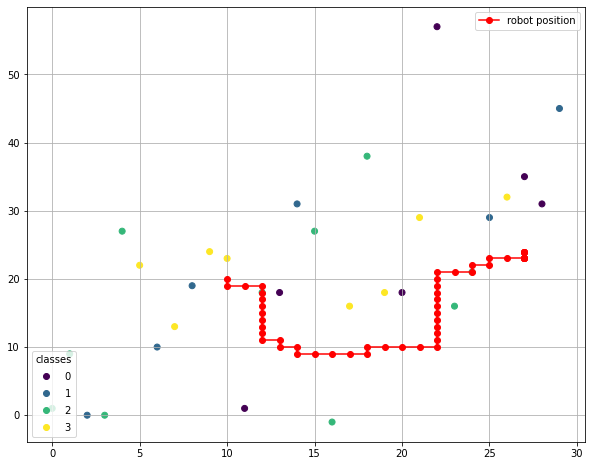

In [26]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

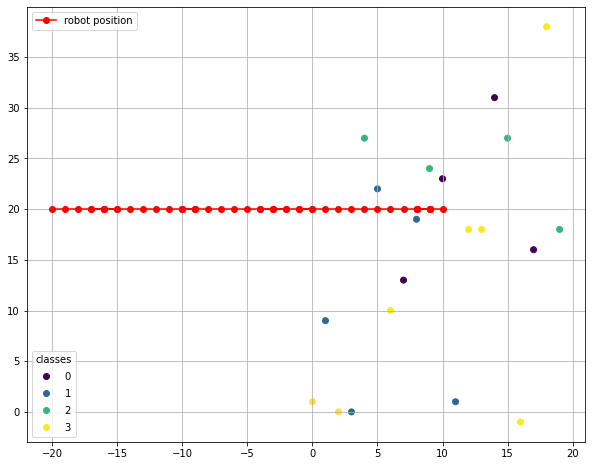

In [17]:
conduct_experiment(x, mean = 3, std = 10, k = 1, n_movements = 50)

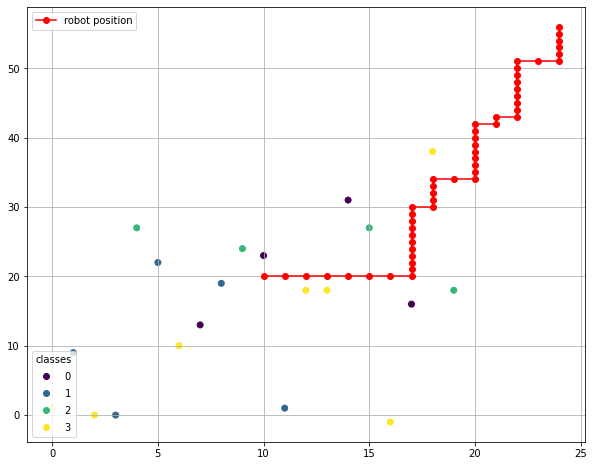

In [18]:
conduct_experiment(x, mean = 3, std = 10, k = 7, n_movements = 50)

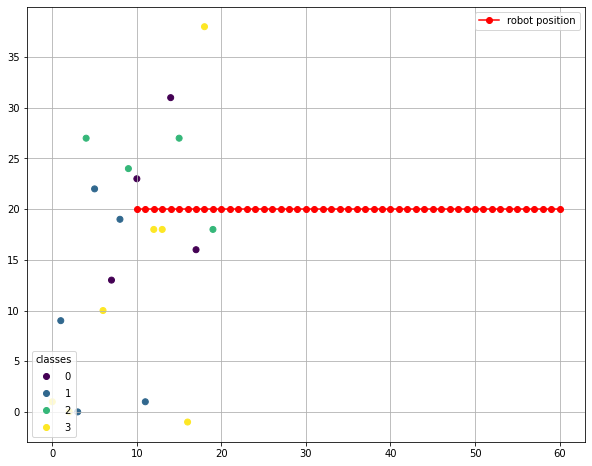

In [19]:
conduct_experiment(x, mean = 3, std = 10, k = 13, n_movements = 50)

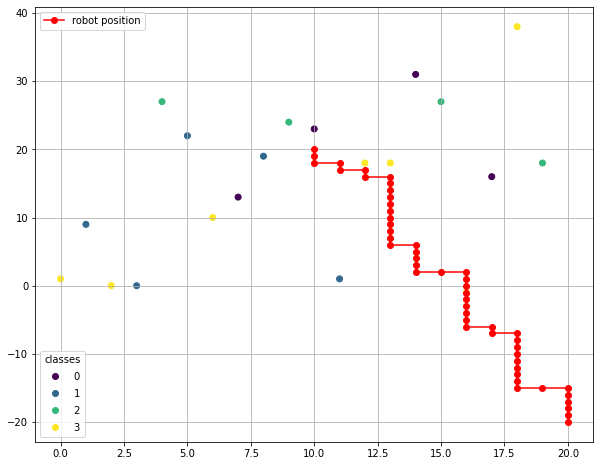

In [20]:
conduct_experiment(x, mean = 3, std = 10, k = 20, n_movements = 50)

Чем больше количество соседей, тем ближе к константной будет модель, поскольку ей нужно будет соответствовать все большему количеству точек. Тогда чем меньше точек, тем более неровным будет движение, тк траектория будет меняться каждый раз при приближению к новому соседу.

Если бы классы присваивались неслучайно, то можно было бы спроектировать движение робота. Даже несмотря на тот факт, что робот может отступить вправо с вероятностью 0.2, это не сильно изменит его траекторию, поскольку ближайшие соседи (если k>1) все равно выведут его на прежний курс.

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [22]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diamonds.csv')
data.head(5)

Mounted at /content/drive


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [23]:
data.isnull().any().any() #тест показал, что их нет

False

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [24]:
data = data.drop('Unnamed: 0', axis=1)  # удалили индекс, тк он нам не нужен

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

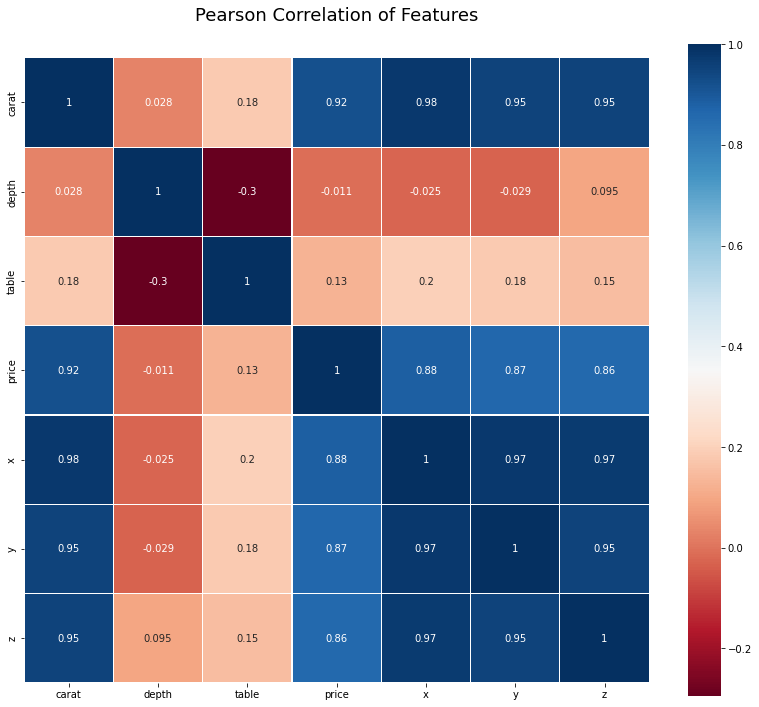

In [25]:
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))

plt.title('Pearson Correlation of Features', y=1.05, size=18)  #КК будут высчитаны по Пирсону
sns.heatmap(data.corr(),
            linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Целевая переменная - цена. Можно заметить, что с ней очень сильно коррелируют вес бриллианта и его параметры длины, ширины и глубины, тогда как глубина относительно среднего длины и ширины (depth) и процентное соотношение верхушки бриллианта с наиболее широкой частью (table) - нет (по свойствам корреляции). Более того, если не будет доказана незначимость парного КК price и depth, то они могут быть отрицательно коррелированы. 

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [26]:
dum = pd.get_dummies(data[['cut', 'color', 'clarity']])
data.drop(['cut', 'color', 'clarity'], axis = 1, inplace = True)
data = pd.concat((data, dum), axis = 1)
data

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,0,1,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='price', inplace=False), data['price'], test_size=0.3, random_state=12345)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [28]:
normalizer = preprocessing.StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

lr = LinearRegression().fit(X_train ,y_train)
predict_train = mean_squared_error(y_train, lr.predict(X_train))
predict_test = mean_squared_error(y_test, lr.predict(X_test))
print ("MSE Train: {}".format(predict_train))
print ("MSE Test: {}".format(predict_test))

MSE Train: 1295920.7310854401
MSE Test: 1263039.4377476852


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [30]:
pd.DataFrame(data = zip(list(data.drop(columns='price', inplace=False)), lr.coef_), columns=['characteristic', 'estimate'])  # просто вывод всех оценок коэффициентов
# pd.DataFrame({'characteristic': list(data), 'estimate': lr.coef_})

,characteristic,estimate
0,carat,5363.933924
1,depth,-99.198416
2,table,-65.084859
3,x,-1544.203392
4,y,417.869993
5,z,-33.589652
6,cut_Fair,-113.684011
7,cut_Good,-44.634931
8,cut_Ideal,49.773719
9,cut_Premium,21.207128


К вещественным переменным относятся переменные carat, depth, table, x, y, z, cut_Fair, cut_Good. При этом на порядок от других отличаются carat, x, y, cut_Fair.

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [31]:
from sklearn.linear_model import Ridge, Lasso

lasso = Lasso(10).fit(X=X_train, y=y_train)
lasso_train = mean_squared_error(y_train, lasso.predict(X_train))
lasso_test = mean_squared_error(y_test, lasso.predict(X_test))

print("MSE Train: {}".format(lasso_train))
print("MSE Test: {}".format(lasso_test))
print("\nDifference for test: {}".format(predict_train-lasso_train))
print("Difference for training: {}".format(predict_test-lasso_test))
# (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

pd.DataFrame(data = lasso.coef_, columns=['estimate'],index=list(data.drop(columns='price', inplace=False)))  # просто вывод всех оценок коэффициентов


MSE Train: 1307725.998357274
MSE Test: 1236326.1133580238

Difference for test: -11805.26727183396
Difference for training: 26713.32438966143


,estimate
carat,4910.850005
depth,-69.309080
table,-52.566899
x,-687.648346
y,-0.000000
z,-38.413035
cut_Fair,-118.101791
cut_Good,-43.895384
cut_Ideal,41.676084
cut_Premium,0.000000


In [32]:
ridge = Ridge(10.0).fit(X_train,y_train)
ridge_train = mean_squared_error(y_train, ridge.predict(X_train))
ridge_test = mean_squared_error(y_test, ridge.predict(X_test))
print ("MSE Train: {}".format(ridge_train))
print ("MSE Test: {}".format(ridge_test))

print("\nDifference for test: {}".format(predict_train-ridge_train))
print("Difference for training: {}".format(predict_test-ridge_test))
pd.DataFrame(data =ridge.coef_, columns=['estimate'], index=list(data.drop(columns='price', inplace=False)))  # просто вывод всех оценок коэффициентов


MSE Train: 1296042.314604562
MSE Test: 1246999.573577879

Difference for test: -121.58351912186481
Difference for training: 16039.864169806242


,estimate
carat,5328.434131
depth,-97.411616
table,-65.191297
x,-1375.358574
y,287.684884
z,-37.322001
cut_Fair,-114.847194
cut_Good,-44.191418
cut_Ideal,50.091871
cut_Premium,19.552975


Заметно, что некоторые веса уменьшились, но (вроде) не так сильно при обоих видах регуляризации. Тем не менее, регуляризация L1 сильнее "штрафовала" данные, тк у нее коэффициенты (в основном) меньше, чем у L2, и некоторые даже занулены.
То есть, можно однозначно сказать, что проблема мультиколинеарности присутствовала в исходных данных что и являлось причиной переобучения модели.

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [33]:
coef_df = pd.DataFrame(data = zip(list(data.drop(columns='price', inplace=False)), lr.coef_), columns=['characteristic', 'no_regularization'])

for alpha in [0.1, 1, 10, 100, 200]:
    lasso = Lasso(alpha).fit(X_train,y_train)
    ridge = Ridge(alpha).fit(X_train,y_train)
    coef_df[f'lasso_{alpha}'] = lasso.coef_
    coef_df[f'ridge_{alpha}'] = ridge.coef_
coef_df

# выводим для удобства все коэффициенты в виде таблицы

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e+09, tolerance: 6.092e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,characteristic,no_regularization,lasso_0.1,ridge_0.1,lasso_1,ridge_1,lasso_10,ridge_10,lasso_100,ridge_100,lasso_200,ridge_200
0,carat,5363.933924,5360.725090,5363.575129,5330.404095,5360.349546,4910.850005,5328.434131,3916.842535,5037.115880,3641.245339,4760.486606
1,depth,-99.198416,-99.434824,-99.181277,-99.612461,-99.026217,-69.309080,-97.411616,-0.000000,-80.480006,-0.000000,-64.463797
2,table,-65.084859,-65.222546,-65.086792,-65.136947,-65.103273,-52.566899,-65.191297,-0.000000,-63.484108,-0.000000,-60.740771
3,x,-1544.203392,-1460.620762,-1542.247237,-1099.467206,-1524.923315,-687.648346,-1375.358574,0.000000,-741.691888,0.000000,-468.104325
4,y,417.869993,337.092331,416.308368,0.000000,402.527413,-0.000000,287.684884,0.000000,-43.983884,0.000000,-45.438508
5,z,-33.589652,-33.077015,-33.630199,-27.414514,-33.991859,-38.413035,-37.322001,0.000000,-55.813068,0.000000,-60.530534
6,cut_Fair,-113.684011,-121.093809,-113.697596,-122.338472,-113.817805,-118.101791,-114.847194,-66.660071,-118.888734,-0.000000,-120.329757
7,cut_Good,-44.634931,-55.914929,-44.629406,-52.354680,-44.580830,-43.895384,-44.191418,-0.000000,-43.671785,-0.000000,-44.497256
8,cut_Ideal,49.773719,30.110473,49.777512,33.852948,49.811010,41.676084,50.091871,17.624260,50.962026,0.000000,51.028809
9,cut_Premium,21.207128,2.398954,21.187267,0.000000,21.012021,0.000000,19.552975,-0.000000,15.415565,-0.000000,15.550036


In [34]:
norms_lasso = list()
norms_ridge = list()
alphas = [0.1, 1, 10, 100, 200]
for alpha in alphas:
    norms_lasso.append(np.linalg.norm(Lasso(alpha).fit(X_train,y_train).coef_)) # просто добавляем все коэффициенты в листы для последующего вывода на график
    norms_ridge.append(np.linalg.norm(Ridge(alpha).fit(X_train,y_train).coef_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e+09, tolerance: 6.092e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


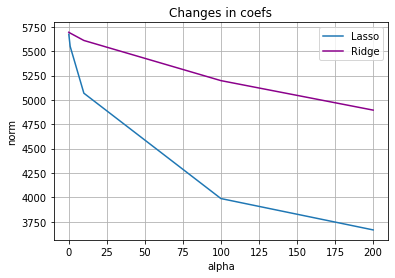

In [35]:
plt.title('Changes in coefs')
plt.xlabel('alpha')
plt.ylabel('norm')
plt.grid()
_ = plt.plot(alphas, norms_lasso, label = 'Lasso')
_ = plt.plot(alphas, norms_ridge, label = 'Ridge', color = 'darkmagenta')
_ = plt.legend()

> Явно заметно, что Lasso более агрессивно уменьшает веса, чем Ridge. Это связано с тем, что в Lasso используется квадрат ошибки, а он штрафует за слишком большие веса намного сильнее.

> Модель Lasso зануляет слишком большие коэффициенты, которые и способствуют переобучению модели. Этот метод регуляризации используют часто, тк он позволяет в большей степени избавиться от  мультиколинеарности.

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [36]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, cv=5)
fitted_lasso_cv = lasso_cv.fit(X_train, y_train)
mean_cv_df = pd.DataFrame(index=fitted_lasso_cv.alphas_, data =np.mean(fitted_lasso_cv.mse_path_, axis = 1), columns=['mean_cv_by_alpha'] )
print(mean_cv_df)
print(f'\nmin mean error: {mean_cv_df.min()[0]}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9926035534.838596, tolerance: 48298505.0637051
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 680214945.1605988, tolerance: 48707112.2777347
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1113224727.313469, tolerance: 49061005.39054556
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1936547359.304

       mean_cv_by_alpha
200.0      1.974936e+06
100.0      1.553493e+06
10.0       1.310855e+06
1.0        1.300018e+06
0.1        1.300965e+06

min mean error: 1300018.430586341


Тогда наименьшее значение средних ошибок достигается при $\alpha=0.1$


**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [37]:
last_lasso = Lasso(1.0).fit(X_train,y_train)
pd.DataFrame(data =  last_lasso.coef_, columns=['estimate'], index=list(data.drop(columns='price', inplace=False)))

,estimate
carat,5330.404095
depth,-99.612461
table,-65.136947
x,-1099.467206
y,0.000000
z,-27.414514
cut_Fair,-122.338472
cut_Good,-52.354680
cut_Ideal,33.852948
cut_Premium,0.000000


Самым информативным оказался вес (что логично, потому что он будет частично отражать размеры), а самыми неинформативными - закодированные цвет G, чистота VS2, форма Premium (то есть, по одному варианту из категориальных признаков) и коэффициент при вещественном признаке ширина (возможно, потому что этот признак уже был учтен в других - например, в `table` или он очень сильно коррелирует с, например, `width`)

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [38]:
predict_lasso = mean_squared_error(y_test, last_lasso.predict(X_test))

print("Difference in MSE between regularized and non-regularized: {}".format(predict_test-predict_lasso))

Difference in MSE between regularized and non-regularized: 30716.82274875068


Разница довольно большая (вроде). Лучше для предсказаний использовать Lasso-регрессию, поскольку она  меньше ошибается в предсказаниях. Это произошло из-за того, что первая модель (с большими коэффициентами) слишком сильно подстроилась под тренировочную выборку и в меньшей степени отражала реальную зависимость целевой переменной от признаков, тогда как при штрафовании модели за большие коэффициенты в Lasso-регрессии мы добились того, что модель не так четко описывает тренировочную выборку , но ближе к действительности.